DEM CRS   : EPSG:27700
DEM shape : (492, 264)
DEM res(m): 2500.0
DEM valid %: 100.0
Land_area_mask % (strict onshore): 29.013457748213845
⚠️ No QML found. Will fall back to [20, 21].

[LCM sampled top values] [(0, 113), (3, 14), (4, 9), (7, 5), (2, 2), (9, 2), (11, 2), (21, 2), (10, 1), (14, 1), (16, 1), (20, 1)]
✅ Using BUILTUP_CODES = [20, 21]
   (If results look wrong, check QML labels or override BUILTUP_CODES manually.)
[Landcover] Excluded % of LAND = 23.74%  codes=[1, 2, 13, 14, 20, 21]
[WDPA] Reading with bbox filter: /Users/wangbobo/Desktop/WDPA_WDOECM_Jan2026_Public_GBR_shp/WDPA_WDOECM_Jan2026_Public_GBR_shp_0/WDPA_WDOECM_Jan2026_Public_GBR_shp-polygons.shp
  features after bbox filter: 3997
[WDPA] Reading with bbox filter: /Users/wangbobo/Desktop/WDPA_WDOECM_Jan2026_Public_GBR_shp/WDPA_WDOECM_Jan2026_Public_GBR_shp_1/WDPA_WDOECM_Jan2026_Public_GBR_shp-polygons.shp
  features after bbox filter: 3999
[WDPA] Reading with bbox filter: /Users/wangbobo/Desktop/WDPA_WDOECM_Jan2026_

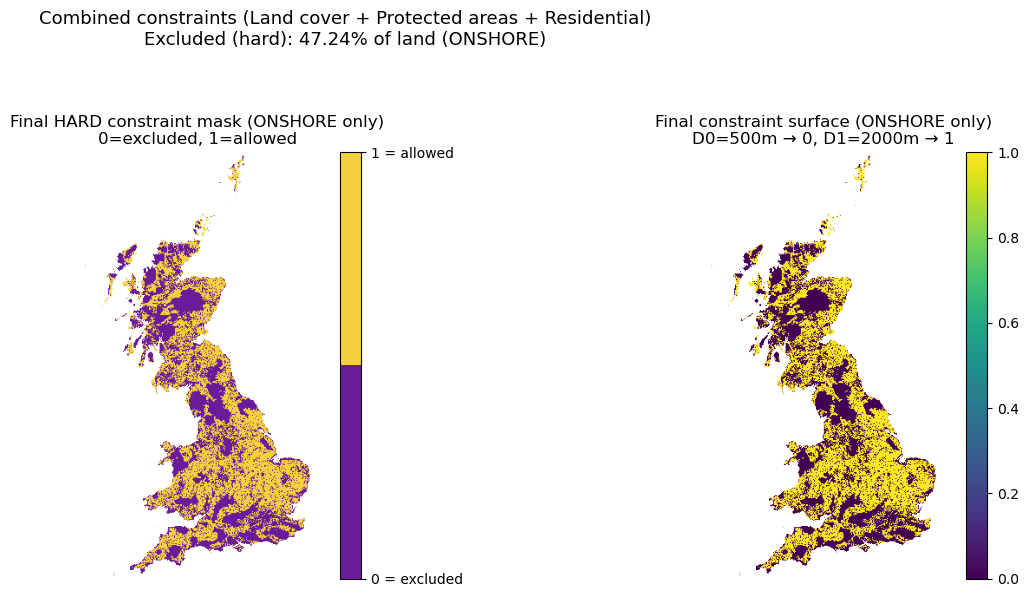

Saved: /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs_constraints/final_constraints_combined.png
All outputs in: /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs_constraints


In [1]:
# ============================================================
# FINAL (MODIFIED): Combine HARD constraints into ONE ONSHORE map
# - Residential built-up codes are AUTO-detected from LCM QML (from txt1 logic)
#
# Constraints:
# 1) Land cover hard exclusion: forests + water + built-up
# 2) Protected areas: WDPA (bbox filter + rasterize)
# 3) Residential proximity: distance-to-built-up (D0=500m -> 0, D1=2000m -> 1)
#
# Outputs:
# 1) final_hard_mask_0_1.tif            (uint8; 0/1; nodata=255 outside onshore mask)
# 2) final_constraint_surface_0_1.tif   (float32; 0..1; nodata=-9999 outside onshore mask)
# 3) final_constraints_combined.png     (SEA/outside-land removed)
# ============================================================

import os
import glob
import re
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
from rasterio.features import rasterize
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.ndimage import distance_transform_edt
import geopandas as gpd
from shapely.geometry import box


TERRAIN_DIR = r"/Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets"
DEM_PATH = os.path.join(TERRAIN_DIR, "terrain.tif")

LCM_DIR = r"/Users/wangbobo/Desktop/uk land cover/data/0e3ab6f8-4a20-4a60-a804-e144fb0bde39"
LANDCOVER_TIF = os.path.join(LCM_DIR, "gblcm2024_25m.tif")


QML_CANDIDATES = [
    os.path.join(LCM_DIR, "lcm_raster.qml"),
    os.path.join(LCM_DIR, "lcm_raster_cb_friendly.qml"),
]

WDPA_DIRS = [
    r"/Users/wangbobo/Desktop/WDPA_WDOECM_Jan2026_Public_GBR_shp/WDPA_WDOECM_Jan2026_Public_GBR_shp_0",
    r"/Users/wangbobo/Desktop/WDPA_WDOECM_Jan2026_Public_GBR_shp/WDPA_WDOECM_Jan2026_Public_GBR_shp_1",
    r"/Users/wangbobo/Desktop/WDPA_WDOECM_Jan2026_Public_GBR_shp/WDPA_WDOECM_Jan2026_Public_GBR_shp_2",
]

OUT_DIR = os.path.join(TERRAIN_DIR, "outputs_constraints")
os.makedirs(OUT_DIR, exist_ok=True)


os.environ["SHAPE_RESTORE_SHX"] = "YES"


EXCLUDE_CODES_LC = [1, 2, 13, 14, 20, 21]

# Residential thresholds:
D0 = 500
D1 = 2000



def read_dem_basegrid(dem_path: str):
    with rasterio.open(dem_path) as src:
        dem = src.read(1).astype("float32")
        meta = src.profile.copy()
        crs = src.crs
        transform = src.transform
        nodata = src.nodata
        bounds = src.bounds

    dem_valid = np.isfinite(dem) if (nodata is None or np.isnan(nodata)) else (dem != nodata)
    dem_res = float(abs(transform.a))
    return dem, meta, crs, transform, bounds, dem_valid, dem_res


def reproject_to_dem_grid(src_tif: str, dem_shape, dem_transform, dem_crs,
                          dst_dtype, src_band=1, src_nodata=None, dst_nodata=0):
    with rasterio.open(src_tif) as src:
        arr = src.read(src_band)
        s_transform = src.transform
        s_crs = src.crs
        s_nodata = src.nodata if src_nodata is None else src_nodata

    dst = np.full(dem_shape, dst_nodata, dtype=dst_dtype)

    reproject(
        source=arr,
        destination=dst,
        src_transform=s_transform,
        src_crs=s_crs,
        dst_transform=dem_transform,
        dst_crs=dem_crs,
        resampling=Resampling.nearest,   # categorical safe
        src_nodata=s_nodata,
        dst_nodata=dst_nodata
    )
    return dst


def smoothstep01(t):
    return t * t * (3.0 - 2.0 * t)


def save_geotiff(path, arr, dem_meta, dtype, nodata_value):
    meta = dem_meta.copy()
    meta.update(dtype=dtype, count=1, compress="lzw", nodata=nodata_value)
    with rasterio.open(path, "w", **meta) as dst:
        dst.write(arr.astype(dtype), 1)



def find_qml_path():
    for p in QML_CANDIDATES:
        if os.path.exists(p):
            return p
   
    c = glob.glob(os.path.join(LCM_DIR, "**", "*.qml"), recursive=True)
    return c[0] if c else None


def parse_qml_palette(qml_path):
    """
    Returns: list of (value:int, label:str)
    Works for typical QGIS paletteEntry nodes.
    """
    with open(qml_path, "r", encoding="utf-8", errors="ignore") as f:
        txt = f.read()

    pattern = r'paletteEntry[^>]*\bvalue="([^"]+)"[^>]*\blabel="([^"]*)"'
    matches = re.findall(pattern, txt)
    palette = []
    for v, lab in matches:
        try:
            vi = int(float(v))
        except:
            continue
        palette.append((vi, lab))
    return palette


def infer_builtup_codes_from_qml(qml_path):
    """
    Identify built-up/urban/residential-like codes using keywords in QML labels.
    Returns: sorted list[int] or [] if none found.
    """
    palette = parse_qml_palette(qml_path)
    keywords = [
        "urban", "built", "built-up", "builtup", "settlement", "residential",
        "suburban", "developed", "town", "city", "village"
    ]
    picked = []
    for v, lab in palette:
        lab_l = (lab or "").lower()
        if any(k in lab_l for k in keywords):
            picked.append(v)
    return sorted(list(set(picked))), palette



if not os.path.exists(DEM_PATH):
    raise FileNotFoundError(f"DEM not found: {DEM_PATH}")

dem, dem_meta, dem_crs, dem_transform, dem_bounds, dem_valid, dem_res = read_dem_basegrid(DEM_PATH)
print("DEM CRS   :", dem_crs)
print("DEM shape :", dem.shape)
print("DEM res(m):", dem_res)


if not os.path.exists(LANDCOVER_TIF):
    raise FileNotFoundError(f"Landcover tif not found: {LANDCOVER_TIF}")

lc_on_dem = reproject_to_dem_grid(
    src_tif=LANDCOVER_TIF,
    dem_shape=dem.shape,
    dem_transform=dem_transform,
    dem_crs=dem_crs,
    dst_dtype=np.int16,
    src_band=1,
    dst_nodata=0  # 0 = unclassified/masked
)


land_area_mask = (lc_on_dem != 0) & dem_valid
print("DEM valid %:", dem_valid.sum() / dem_valid.size * 100)
print("Land_area_mask % (strict onshore):", land_area_mask.sum() / land_area_mask.size * 100)


QML_PATH = find_qml_path()
BUILTUP_CODES = None
palette = None

if QML_PATH:
    print("✅ Found QML:", QML_PATH)
    BUILTUP_CODES, palette = infer_builtup_codes_from_qml(QML_PATH)
    if BUILTUP_CODES:
        print("✅ Auto-detected BUILTUP_CODES:", BUILTUP_CODES)
    else:
        print("⚠️ QML found but no built-up codes detected by keywords. Will fall back to [20, 21].")
else:
    print("⚠️ No QML found. Will fall back to [20, 21].")

if not BUILTUP_CODES:
    BUILTUP_CODES = [20, 21]


sample = lc_on_dem[::30, ::30]
vals, counts = np.unique(sample, return_counts=True)
top = sorted(zip(vals.tolist(), counts.tolist()), key=lambda x: x[1], reverse=True)[:20]
print("\n[LCM sampled top values]", top)
print("✅ Using BUILTUP_CODES =", BUILTUP_CODES)
print("   (If results look wrong, check QML labels or override BUILTUP_CODES manually.)")


excluded_lc = np.isin(lc_on_dem, EXCLUDE_CODES_LC) & land_area_mask
lc_mask = np.ones(dem.shape, dtype=np.uint8)
lc_mask[excluded_lc] = 0
lc_mask[~land_area_mask] = 0

excluded_lc_pct = excluded_lc.sum() / land_area_mask.sum() * 100.0
print(f"[Landcover] Excluded % of LAND = {excluded_lc_pct:.2f}%  codes={EXCLUDE_CODES_LC}")


excluded_wdpa = np.zeros(dem.shape, dtype=np.uint8)

dem_bbox_geom = box(dem_bounds.left, dem_bounds.bottom, dem_bounds.right, dem_bounds.top)
bbox_gdf = gpd.GeoDataFrame(geometry=[dem_bbox_geom], crs=dem_crs)

for d in WDPA_DIRS:
    shp_list = sorted(glob.glob(os.path.join(d, "*.shp")))
    if not shp_list:
        raise FileNotFoundError(f"No .shp found in: {d}")
    shp = shp_list[0]
    print(f"[WDPA] Reading with bbox filter: {shp}")

    tmp = gpd.read_file(shp, rows=1)
    wdpa_crs = tmp.crs
    del tmp
    if wdpa_crs is None:
        raise ValueError(f"{shp} has no CRS (.prj missing?)")

    bbox_in_wdpa = bbox_gdf.to_crs(wdpa_crs).geometry.iloc[0]
    wdpa = gpd.read_file(shp, bbox=bbox_in_wdpa)
    print("  features after bbox filter:", len(wdpa))
    if len(wdpa) == 0:
        continue

    if wdpa.crs != dem_crs:
        wdpa = wdpa.to_crs(dem_crs)

    wdpa = wdpa[wdpa.geometry.notnull()].copy()
    wdpa["geometry"] = wdpa.geometry.buffer(0)
    wdpa = wdpa[~wdpa.geometry.is_empty].copy()

    shapes = ((geom, 1) for geom in wdpa.geometry)
    part = rasterize(
        shapes=shapes,
        out_shape=dem.shape,
        transform=dem_transform,
        fill=0,
        dtype="uint8",
        all_touched=False
    )
    excluded_wdpa = np.maximum(excluded_wdpa, part)
    del wdpa, part


excluded_wdpa[~land_area_mask] = 0
wdpa_mask = (1 - excluded_wdpa).astype(np.uint8)
wdpa_mask[~land_area_mask] = 0

excluded_wdpa_pct = excluded_wdpa.sum() / land_area_mask.sum() * 100.0
print(f"[WDPA] Excluded % of LAND = {excluded_wdpa_pct:.2f}%")


builtup = np.isin(lc_on_dem, BUILTUP_CODES) & land_area_mask
builtup_uint8 = builtup.astype(np.uint8)

dist_px = distance_transform_edt(1 - builtup_uint8)
dist_m = dist_px * dem_res

t = (dist_m - D0) / (D1 - D0)
t = np.clip(t, 0.0, 1.0)
res_suit = smoothstep01(t).astype(np.float32)
res_suit[builtup_uint8 == 1] = 0.0
res_suit[~land_area_mask] = np.nan


res_hard = (dist_m > D0).astype(np.uint8)
res_hard[builtup_uint8 == 1] = 0
res_hard[~land_area_mask] = 0

excluded_res_pct = ((dist_m <= D0) & land_area_mask).sum() / land_area_mask.sum() * 100.0
print(f"[Residential] Excluded (<= {D0}m) % of LAND = {excluded_res_pct:.2f}%   (D1={D1}m for ramp)")

final_hard = (lc_mask & wdpa_mask & res_hard).astype(np.uint8)
excluded_final_pct = (final_hard[land_area_mask] == 0).sum() / land_area_mask.sum() * 100.0
print(f"[FINAL HARD] Excluded % of LAND = {excluded_final_pct:.2f}%")

final_surface = (lc_mask.astype(np.float32) * wdpa_mask.astype(np.float32) * res_suit).astype(np.float32)
final_surface[~land_area_mask] = np.nan


final_hard_plot = final_hard.astype(np.float32)
final_hard_plot[~land_area_mask] = np.nan
final_surface_plot = final_surface.copy()
final_surface_plot[~land_area_mask] = np.nan

hard_tif = os.path.join(OUT_DIR, "final_hard_mask_0_1.tif")
hard_out = final_hard.copy()
hard_out[~land_area_mask] = 255
save_geotiff(hard_tif, hard_out, dem_meta, dtype="uint8", nodata_value=255)
print("Saved:", hard_tif)

surf_tif = os.path.join(OUT_DIR, "final_constraint_surface_0_1.tif")
surf_out = np.where(np.isnan(final_surface_plot), -9999.0, final_surface_plot).astype(np.float32)
save_geotiff(surf_tif, surf_out, dem_meta, dtype="float32", nodata_value=-9999.0)
print("Saved:", surf_tif)


hard_cmap = ListedColormap(["#6a1b9a", "#f4d03f"])
hard_cmap.set_bad(color="white", alpha=0.0)

cmap2 = plt.cm.viridis.copy()
cmap2.set_bad(color="white", alpha=0.0)

fig = plt.figure(figsize=(14, 6))

ax1 = plt.subplot(1, 2, 1)
im1 = ax1.imshow(final_hard_plot, cmap=hard_cmap, vmin=0, vmax=1)
ax1.set_title("Final HARD constraint mask (ONSHORE only)\n0=excluded, 1=allowed")
ax1.axis("off")
cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
cbar1.set_ticks([0, 1])
cbar1.set_ticklabels(["0 = excluded", "1 = allowed"])

ax2 = plt.subplot(1, 2, 2)
im2 = ax2.imshow(final_surface_plot, cmap=cmap2, vmin=0, vmax=1)
ax2.set_title(f"Final constraint surface (ONSHORE only)\nD0={D0}m → 0, D1={D1}m → 1")
ax2.axis("off")
plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

fig.suptitle(
    f"Combined constraints (Land cover + Protected areas + Residential)\n"
    f"Excluded (hard): {excluded_final_pct:.2f}% of land (ONSHORE)",
    fontsize=13
)

out_png = os.path.join(OUT_DIR, "final_constraints_combined.png")
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig(out_png, dpi=300)
plt.show()

print("Saved:", out_png)
print("All outputs in:", OUT_DIR)
